In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from LPSolver import LPSolver
from QPSolver import QPSolver
from SOCPSolver import SOCPSolver
from LassoSolver import LassoSolver
import cvxpy as cp

Not able to run with GPU
Not able to run with GPU
Not able to run with GPU
Not able to run with GPU


In [8]:
rng = np.random.default_rng(10)

### Generate a feasible problem instance

In [176]:
m = 80  # number of equality constraints -- keep lower than number of variables to ensure there are multiple solutions to the problem
n = 100  # number of variables

A = rng.normal(size = (m,n))

random_row_index = np.random.choice(m)

# Set all entries in the selected row to their absolute values
A[random_row_index, :] = np.abs(A[random_row_index, :])

b = A@np.abs(rng.normal(size = (n,)))
c = rng.normal(size = (n,))

In [136]:
n = 1000
m = 500
C = np.random.random((m,n))
C = np.where(np.random.binomial(1, 0.10, C.shape), C, 0)  # <- apply a random mask with 10% density  (A will be 90% sparse)
d = np.random.randint(low=1, high=30, size=C.shape[0])
# b_vec = np.sum(A, axis=1) + 10

c = np.random.randint(low=1, high=n, size=C.shape[1]) - n/2

### Create a LPSolver object

Can specify use_gpu = True if you want to run with a GPU. GPU solver typically starts to surpass performance of CPU solver ~500 variables (depending on system)

Also able to make multiple instances of this object to compare different hyperparameters

In [187]:
def load_data(X_train_path, y_train_path):
    X_train = np.loadtxt(X_train_path, delimiter=",")
    X_train = np.hstack([np.ones(X_train.shape[0])[:, np.newaxis], X_train])
    y_train = np.loadtxt(y_train_path, delimiter=",")
    return X_train, y_train

def get_weights(groups):

    group_sizes = list(map(len, groups))
    weights = np.sqrt(group_sizes)
    return weights

LAMBDA = 0.02
GROUPS = [
    [0],
    [1],
    [2],
    [3, 4, 5, 6, 7],
    [8, 9, 10, 11, 12, 13],
    [14, 15],
    [16],
    [17],
    [18],
]
FSTAR = 49.9649387126726
w = get_weights(GROUPS)[1:]

X, Y = load_data('/Users/frankdeguire/Documents/EE364B/HW7/X_train (1).csv', '/Users/frankdeguire/Documents/EE364B/HW7/Y_train (1).csv')

In [188]:

P = np.zeros((27,27))
P[:19,:19] = 1/(X.shape[0]) * X.T@X
q = np.zeros(27)
q[:19] = -1/(X.shape[0]) * Y.T@X
q[19:] = LAMBDA * w
A = []
c = []
for i in range(len(GROUPS)-1):
    z = np.zeros((27,27))
    zv = np.zeros(27)
    z[GROUPS[i+1], GROUPS[i+1]] = 1
    A.append(z)
    zv[i+19] = 1
    c.append(zv)

In [167]:
qs.cvxpy_val, qs.cvxpy_sol

(-427.65875185359926,
 array([ 2.70214956e+01,  2.62827856e+01, -1.86037253e+00,  2.85132071e-09,
        -9.47182257e-08,  7.57811594e-09, -2.26338093e-09,  7.58465983e-09,
        -4.49438455e-01, -5.08003648e-01, -5.69580130e-01, -5.32500918e-01,
         3.37863308e-02, -5.69535567e-01, -5.86121772e+00, -1.01077247e+01,
         3.09456643e+00, -2.07725434e+01,  9.35626027e+00,  2.62827860e+01,
         1.86037309e+00,  3.21659472e-07,  1.18048893e+00,  1.16841765e+01,
         3.09456686e+00,  2.07725439e+01,  9.35626070e+00]))

In [169]:
qs.cvxpy_val + 1/(2*X.shape[0])*Y.T@Y

49.96493879337402

In [433]:
Z = []
Zb = []
for _ in range(50):
    z = np.zeros(100)
    z[2*_:2*_+2] = 2.5
    Zb.append(np.ones(100)*-0.5)
    Z.append(z)

In [189]:
""""Initialize LP problem of form:
        Minimize c^T x
        Subject to Ax == b
                   Cx <= d
                   x >= 0

Can leave A, b, C, d, and c as None or specify matrices/vectors to constrain the problem
Set sign = +/- 1 if you want to constraint x to be positive or negative
"""
#A = np.zeros((2, len(c)))
#A[0,148] = 5
#A[1,590] = 4.5
#b = np.array([2,2])

qs= SOCPSolver(P=P, q=q,
        A=A,
        b=None,
        c=c,
        d=None,
        F=None,
        g=None,
        lower_bound=None,
        upper_bound=None,
        t0=0.01,
        phase1_t0=0.001,
        max_outer_iters=50,
        max_inner_iters=500,
        epsilon=1e-8,
        inner_epsilon=1e-5,
        check_cvxpy=True,
        linear_solve_method="cholesky",
        max_cg_iters=50,
        alpha=0.2,
        beta=0.6,
        mu=15,
        suppress_print=False,
        use_gpu=False,
        try_diag=True,
        track_loss=False,
        use_psd_condition=True,
        x0=np.hstack((np.ones(19), np.ones(8)*10)))


Is testing CVXPY
Starting slack of -9.0


In [146]:
""""Initialize LP problem of form:
        Minimize c^T x
        Subject to Ax == b
                   Cx <= d
                   x >= 0

Can leave A, b, C, d, and c as None or specify matrices/vectors to constrain the problem
Set sign = +/- 1 if you want to constraint x to be positive or negative
"""
A = np.zeros((2, len(c)))
A[0,148] = 5
A[1,590] = 4.5
b = np.array([2,2])

ls= LPSolver(c=c,
        A=A,
        b=b,
        C=C,
        d=d,
        use_gpu=False,
        upper_bound=3,
        lower_bound=0,
        t0=0.1,
        max_outer_iters=50,
        max_inner_iters=50,
        epsilon=1e-7,
        inner_epsilon=1e-5,
        check_cvxpy=True,
        linear_solve_method="cholesky",
        max_cg_iters=50,
        alpha=0.2,
        beta=0.6,
        mu=50,
        suppress_print=False,
        phase1_t0=2,)


Is testing CVXPY
Starting slack of 94.6251


#### Compare LPSolver solution to the CVXPY solution
Check the ls.value parameter if you want to extract the value of the solution, use ls.xstar to get the minimizer

In [367]:
qs.cvxpy_val + Y.T@Y/(2*X.shape[0])

49.964938793374245

In [171]:
len(qs.phase1_solver.inner_iters)

7

In [168]:
qs.cvxpy_val

-427.65875185359926

In [148]:
ls.inner_iters

[15, 15, 16, 15, 14, 12, 15, 15, 1]

In [190]:
qs.solve(track_loss=True) - qs.cvxpy_val

proceeding to solve method
Objective value is now 1006.8177889158178
Objective value is now -333.1646638673395
Objective value is now -422.1863940182036
Objective value is now -427.37305561523834
Objective value is now -427.64139091687446
REACHED MAX ITERATIONS: Problem likely infeasible or unbounded (Likely infeasible)
Objective value is now -427.65769848686494
Reached max Newton steps during 6th centering step (t=7593.75)
Objective value is now -427.6586820762397
REACHED MAX ITERATIONS: Problem likely infeasible or unbounded (Likely infeasible)
Objective value is now -427.6587471225274
Reached max Newton steps during 8th centering step (t=1708593.75)
Cholesky solver failed due to numeric instability. Proceeding with Numpy solve...
REACHED MAX ITERATIONS: Problem likely infeasible or unbounded (Likely infeasible)
Objective value is now -427.65875166645344
Reached max Newton steps during 9th centering step (t=25628906.25)
Objective value is now -427.65875182806906
Objective value is no

2.5530198399792425e-08

In [183]:
qs.inner_iters, qs.phase1_solver.inner_iters

([134, 7, 7, 7, 8, 9, 8, 10, 7, 6], [354, 2])

In [464]:
qs.fm.slacks, np.linalg.norm(qs.xstar)

(array([2.7906033e-10]), 9.99999999972094)

In [452]:
np.linalg.norm(A@qs.cvxpy_sol - b)

3.3170223809269156e-14

In [451]:
np.linalg.norm(A@qs.xstar - b)

15.799205345251478

In [446]:
qs.value, qs.cvxpy_val

(-30.409726254575286, -19.217544701770343)

/Users/frankdeguire/Documents/EE364B/Final Project/InteriorPoint-GPU/SOCPSolver.py:775: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax.set_yscale("log")


<Axes: title={'center': 'Convergence of SOCPSolver'}, xlabel='Cumulative Newton iterations', ylabel='Optimality gap'>

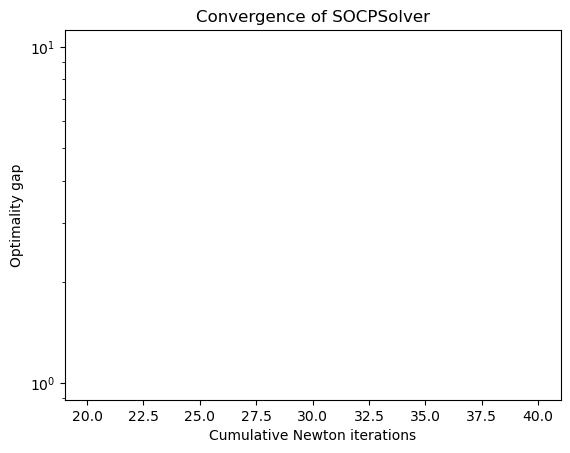

In [447]:
qs.plot()

### Benchmark LPSolver times vs. CVXPY
Can also generate multiple instances of LP to benchmark times of different hyperparameters

In [ ]:
%%timeit
x = cp.Variable(len(c))
obj = cp.Minimize(c.T@x)
constr = [A@x == b,
        x <= 0]
prob = cp.Problem(obj, constr)
prob.solve(solver='CLARABEL')


4.71 s ± 40.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
%timeit ls.solve(resolve=True)

2.03 s ± 3.97 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
%timeit ls_gpu.solve(resolve=True)

250 ms ± 1.86 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


<Axes: title={'center': 'Convergence of LPSolver'}, xlabel='Cumulative Newton iterations', ylabel='Optimality gap'>

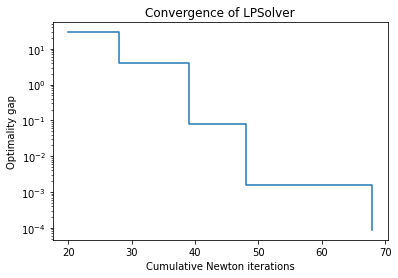

In [ ]:
ls_gpu.plot()

In [24]:
a = np.zeros((1000,1000))
b = np.zeros((1000,1000))
a[np.random.randint(0,1000,100), np.random.randint(0,1000,100)] = np.random.rand()
b[np.random.randint(0,1000,100), np.random.randint(0,1000,100)] = np.random.rand()

In [26]:
%timeit (a != b).any()

681 µs ± 5.22 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [68]:
c = np.random.rand(1000)
x = np.random.rand(1000)

In [69]:
%timeit np.linalg.norm(x)

5.39 µs ± 1.25 µs per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [70]:
%timeit (x**2).sum()

4.53 µs ± 915 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [71]:
%timeit 1/2*x

2.08 µs ± 469 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)


In [78]:
%timeit np.zeros(x.shape)

1.09 µs ± 397 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)


In [81]:
g = 0
g += x
g

array([0.75545756, 0.41672275, 0.06912409, 0.23997814, 0.01671793,
       0.89558356, 0.25314173, 0.52484432, 0.81962239, 0.02955265,
       0.00457799, 0.10345449, 0.58745795, 0.65891478, 0.64468184,
       0.90898426, 0.59667798, 0.14502261, 0.42271814, 0.73423617,
       0.25735192, 0.02847865, 0.17449341, 0.30695361, 0.85820232,
       0.74308392, 0.81096298, 0.89529392, 0.74620993, 0.2965595 ,
       0.50595708, 0.7179588 , 0.10432022, 0.97712471, 0.1557568 ,
       0.45944053, 0.74125415, 0.69201507, 0.55147944, 0.06056547,
       0.01848532, 0.17480287, 0.80769649, 0.93085935, 0.69426876,
       0.66500501, 0.49501882, 0.97615822, 0.42054612, 0.30722835,
       0.03359151, 0.7512889 , 0.63901038, 0.94358964, 0.85846972,
       0.54598312, 0.03607403, 0.59524112, 0.66227863, 0.05850547,
       0.62262215, 0.26177948, 0.24076525, 0.18874621, 0.21778093,
       0.42871048, 0.06086839, 0.03904282, 0.06275885, 0.16913612,
       0.98021798, 0.49594167, 0.99756895, 0.46140581, 0.86778

In [79]:
%timeit 0*x

2.05 µs ± 158 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)
